In [58]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from keras.layers import Flatten,Dropout,Dense,BatchNormalization,Conv2D,MaxPooling2D,Conv2DTranspose,concatenate,Input
from keras.models import Model
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [1]:
def horizontalFlip(arr):
    arr1 = cv2.flip(arr,0)
    return arr1
def verticalFlip(arr):
    arr1 = cv2.flip(arr,1)
    return arr1
def rotate90(arr):
    arr1 = cv2.rotate(arr,cv2.ROTATE_90_CLOCKWISE)
    return arr1
def rotate180(arr):
    arr1 = cv2.rotate(arr,cv2.ROTATE_180)
    return arr1
def rotate270(arr):
    arr1 = cv2.rotate(arr,cv2.ROTATE_90_COUNTERCLOCKWISE)
    return arr1

In [466]:
inputs= list()
outputs = list()
initial_path = 'data/input/'
output_path = 'data/discs/'
max_images = 100+1
N=128
for i in range(1,max_images):
    

    curr_path = output_path + str(i) + '.tif'
    curr_image = cv2.imread(curr_path,cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(curr_image,(N,N))
    outputs.append(tf.convert_to_tensor(resized_image))
    curr1 = horizontalFlip(resized_image)
    curr2 = verticalFlip(resized_image)
    curr3 = rotate90(resized_image)
    curr4 = rotate180(resized_image)
    curr5 = rotate270(resized_image)
    outputs.append(tf.convert_to_tensor(curr1))
    outputs.append(tf.convert_to_tensor(curr2))
    outputs.append(tf.convert_to_tensor(curr3))
    outputs.append(tf.convert_to_tensor(curr4))
    outputs.append(tf.convert_to_tensor(curr5))
    
    
    curr_path = initial_path + str(i) + '.png'

    curr_image = cv2.imread(curr_path)
    resized_image = cv2.resize(curr_image,(N,N))
    inputs.append(tf.convert_to_tensor(resized_image))# numpy arrays convert to tensor
    
    curr1 = horizontalFlip(resized_image)
    curr2 = verticalFlip(resized_image)
    curr3 = rotate90(resized_image)
    curr4 = rotate180(resized_image)
    curr5 = rotate270(resized_image)
    inputs.append(tf.convert_to_tensor(curr1))
    inputs.append(tf.convert_to_tensor(curr2))
    inputs.append(tf.convert_to_tensor(curr3))
    inputs.append(tf.convert_to_tensor(curr4))
    inputs.append(tf.convert_to_tensor(curr5))
    


In [461]:
max_images = len(inputs)
print(max_images)
for index in range(1, max_images+1):
    inputs[index-1] = tf.divide(tf.cast(inputs[index-1], tf.float32), 255.0)
    outputs[index-1] = tf.divide(tf.cast(outputs[index-1], tf.float32), 255.0)

600
(1293014418, 1358838690)


In [469]:
def createModel(input_size=(N, N, 3)):
    ins = tf.keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(4, 3, activation='relu', padding='same')(ins)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(8, 5, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(16, 7, activation='relu', padding='same')(pool2)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat1 = layers.Concatenate(axis=3)([conv2, up1])
    conv4 = layers.Conv2DTranspose(8, 2, activation='relu', padding='same')(concat1)

    conv4 = layers.Dropout(0.1)(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = layers.Concatenate(axis=3)([conv1, up2])
    conv5 = layers.Conv2DTranspose(4, 2, activation='relu', padding='same')(concat2)
    
    drop = layers.Dropout(0.1)(conv5)

    # Output layer
    outs = layers.Conv2D(1, 1, activation='sigmoid')(drop)

    model = models.Model(inputs=ins, outputs=outs)
    return model
model = createModel()
model.compile(optimizer='adam', loss='binary_crossentropy')


model.summary()

Model: "functional_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_53 (InputLayer)   │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_236 (Conv2D)           │ (None, 128, 128, 4)       │             112 │ input_layer_53[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_92              │ (None, 64, 64, 4)         │               0 │ conv2d_236[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_237 (Conv2D)           │ (None, 64, 64, 8)         │             808 │ max_pooling2d_92[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_93              │ (None, 32, 32, 8)         │               0 │ conv2d_237[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_238 (Conv2D)           │ (None, 32, 32, 16)        │           6,288 │ max_pooling2d_93[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_88              │ (None, 64, 64, 16)        │               0 │ conv2d_238[0][0]           │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_88 (Concatenate)  │ (None, 64, 64, 24)        │               0 │ conv2d_237[0][0],          │
│                               │                           │                 │ up_sampling2d_88[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_80           │ (None, 64, 64, 8)         │             776 │ concatenate_88[0][0]       │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_85 (Dropout)          │ (None, 64, 64, 8)         │               0 │ conv2d_transpose_80[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_89              │ (None, 128, 128, 8)       │               0 │ dropout_85[0][0]           │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_89 (Concatenate)  │ (None, 128, 128, 12)      │               0 │ conv2d_236[0][0],          │
│                               │                           │                 │ up_sampling2d_89[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_81           │ (None, 128, 128, 4)       │             196 │ concatenate_89[0][0]       │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 8,185 (31.97 KB)

 Trainable params: 8,185 (31.97 KB)

 Non-trainable params: 0 (0.00 B)

In [462]:
train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(inputs, outputs, test_size=0.1, random_state=41)
train_inputs = tf.stack(train_inputs, axis=0)
test_inputs = tf.stack(test_inputs, axis=0)
train_outputs = tf.stack(train_outputs, axis=0)
test_outputs = tf.stack(test_outputs, axis=0)

In [463]:
model.fit(train_inputs, train_outputs, epochs=200, validation_data=(test_inputs, test_outputs))

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - loss: 0.0485 - val_loss: 0.0084
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0095 - val_loss: 0.0066
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0080 - val_loss: 0.0061
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0069 - val_loss: 0.0048
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0063 - val_loss: 0.0045
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3

In [ ]:
precision=0
recall=0
accuracy=0
F1=0
specificity=0
t_count=600
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
arr=np.zeros((N,N),dtype=np.uint8)

for i1 in range(t_count):
    print(i1)
    test_preds = model.predict(tf.expand_dims(inputs[i1], 0))
    test_preds[0]*=255
    for i in range(N):
        for j in range(N):
            arr[i][j]=test_preds[0][i][j][0]
    check_against=np.array(outputs[i1])
    arr = cv2.GaussianBlur(arr,(5,5),0)
    __,th = cv2.threshold(arr,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    TP = np.sum((th == check_against) & (th == 1))
    TN = np.sum((th == check_against) & (th == 0))
    FP = np.sum((th != check_against) & (th == 1))
    FN = np.sum((th != check_against) & (th == 0))
    
    precision += (TP) / (TP + FP)
    recall += (TP) / (TP + FN) 
    accuracy += (TP + TN) / (N * N)
    specificity += TN / (TN + FP)
precision/=t_count
recall/=t_count
accuracy/=t_count
F1 = (2 * precision * recall) / (precision + recall)
specificity/=t_count
print("Accuracy = ",accuracy)
print("recall = ",recall)
print("precision = ",precision)
print("specificity = ",specificity)
print("F1 = ",F1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


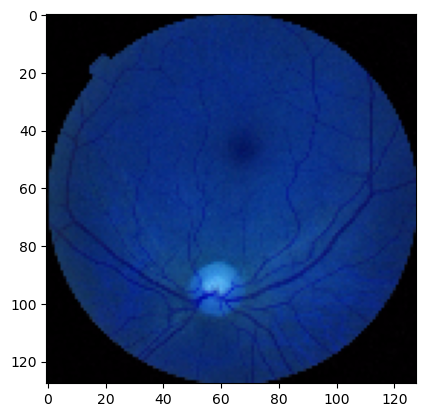

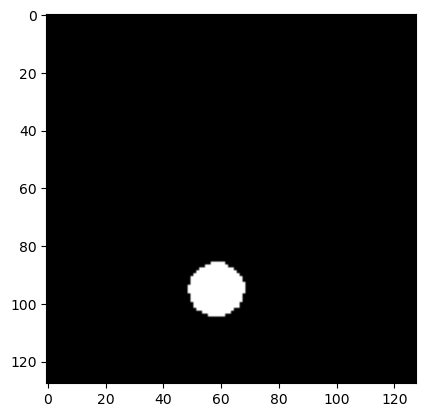

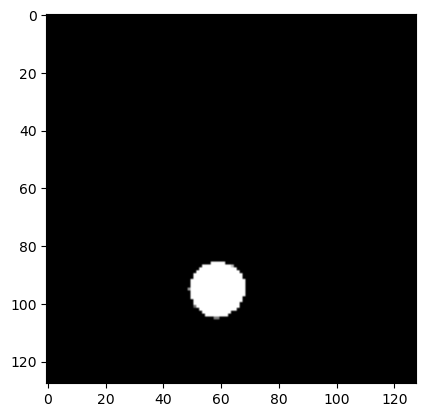

In [455]:
check_num=41

test_preds = model.predict(tf.expand_dims(inputs[check_num], 0))
test_preds[0]*=255
arr=np.zeros((N,N),dtype=np.uint8)
for i in range(N):
    for j in range(N):
        arr[i][j]=test_preds[0][i][j][0]
arr = cv2.GaussianBlur(arr,(5,5),0)
__,th = cv2.threshold(arr,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
#th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=1)


#print(test_preds[0])
plt.imshow(inputs[check_num],'gray')
plt.show()
plt.imshow(th, cmap='gray')
plt.show()
plt.imshow(outputs[check_num],'gray')
plt.show()
#print(model_stats(model))

In [454]:
#model.save('new_discs.keras')